In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc,confusion_matrix
)
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

In [3]:
# 1. Load dataset
# wdbc.data does not have headers, so we define them
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
data = pd.read_csv("wdbc.data", header=None, names=columns)

In [4]:
# 2. Prepare features and target
X = data.drop(["ID", "Diagnosis"], axis=1)
y = data["Diagnosis"].map({"M": 1, "B": 0})  # Malignant=1, Benign=0

In [5]:

# 4. Preprocessor (scaling not needed for trees, but kept for pipeline consistency)
num_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), num_features)],
    remainder="drop"
)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                               random_state=42))
])

In [8]:
param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__learning_rate": [0.01, 0.1, 1.0],
    "clf__estimator__max_depth": [1, 2]
}

In [9]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring={"accuracy": "accuracy", "f1": "f1_macro"},  # both metrics
    refit="accuracy",   # model chosen based on accuracy
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__estimator__max_depth': [1, 2], 'clf__learning_rate': [0.01, 0.1, ...], 'clf__n_estimators': [50, 100, ...]}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_macro'}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [10]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nBest Hyperparameters (from training CV):", grid.best_params_)
print("Test Accuracy:", acc)
print("Test F1 Score:", f1)


Best Hyperparameters (from training CV): {'clf__estimator__max_depth': 1, 'clf__learning_rate': 1.0, 'clf__n_estimators': 200}
Test Accuracy: 0.9736842105263158
Test F1 Score: 0.9629629629629629


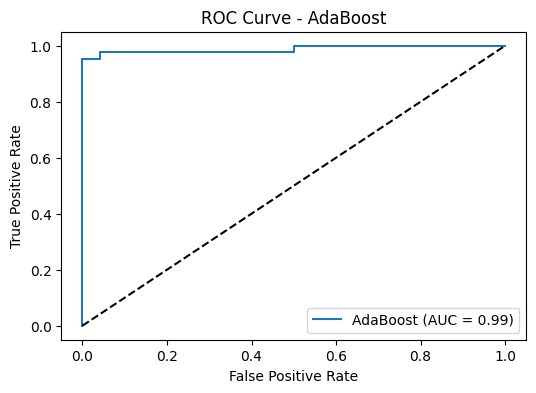

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.show()

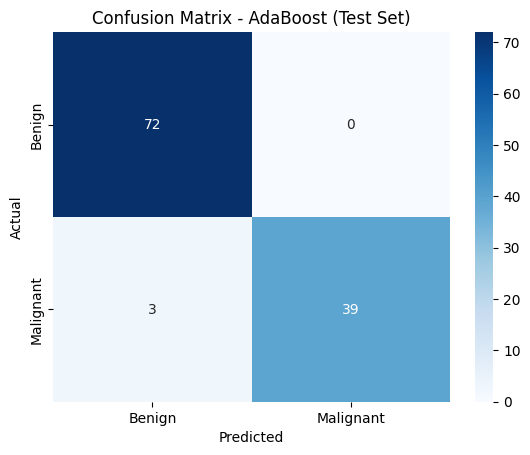

In [12]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AdaBoost (Test Set)")
plt.show()

/tmp/ipykernel_38447/1424558563.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


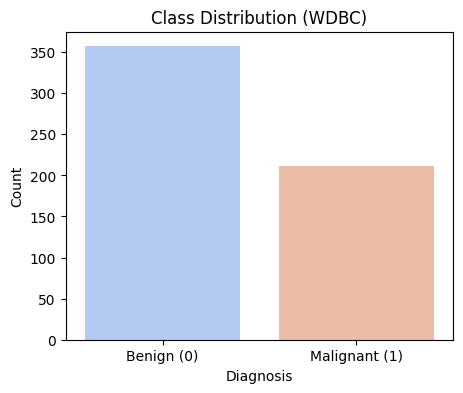

/tmp/ipykernel_38447/1424558563.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


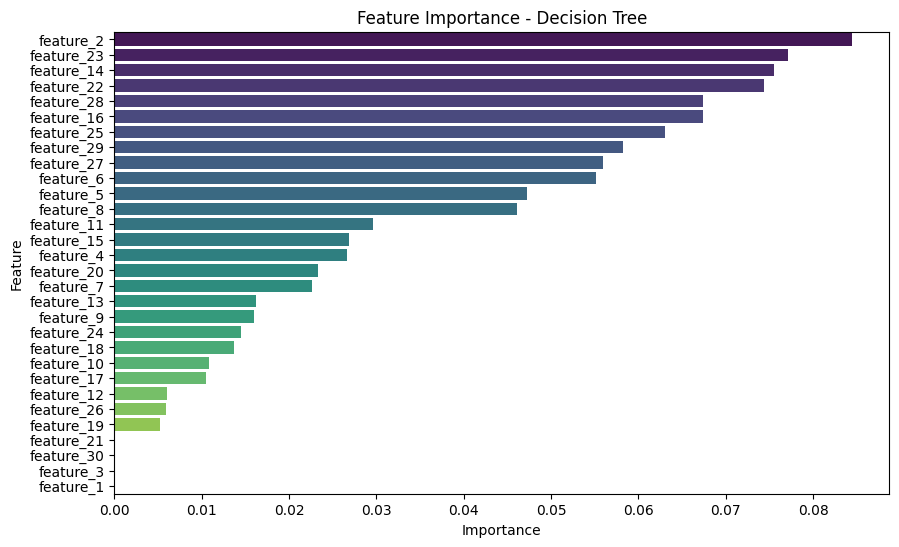

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---- Class distribution ----
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="coolwarm")
plt.xticks([0,1], ["Benign (0)", "Malignant (1)"])
plt.title("Class Distribution (WDBC)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

# ---- Feature importance (from Decision Tree) ----
best_clf = best_model.named_steps["clf"]
importances = best_clf.feature_importances_
features = X.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [14]:
results = pd.DataFrame(grid.cv_results_)

table = results[[
    "param_clf__n_estimators",
    "param_clf__learning_rate",
    "param_clf__estimator__max_depth",
    "mean_test_accuracy",
    "mean_test_f1"
]].copy()

table = table.rename(columns={
    "param_clf__n_estimators": "n_estimators",
    "param_clf__learning_rate": "learning_rate",
    "param_clf__estimator__max_depth": "max_depth",
    "mean_test_accuracy": "Accuracy",
    "mean_test_f1": "F1_score"
})

print("Table 2: AdaBoost - Hyperparameter Tuning")
print(table[["n_estimators", "learning_rate", "max_depth", "Accuracy", "F1_score"]])

Table 2: AdaBoost - Hyperparameter Tuning
    n_estimators  learning_rate  max_depth  Accuracy  F1_score
0             50           0.01          1  0.923077  0.915693
1            100           0.01          1  0.925275  0.918724
2            200           0.01          1  0.931868  0.926145
3             50           0.10          1  0.949451  0.945670
4            100           0.10          1  0.951648  0.948440
5            200           0.10          1  0.951648  0.948224
6             50           1.00          1  0.962637  0.959723
7            100           1.00          1  0.960440  0.957480
8            200           1.00          1  0.964835  0.962262
9             50           0.01          2  0.938462  0.933790
10           100           0.01          2  0.936264  0.931637
11           200           0.01          2  0.945055  0.941220
12            50           0.10          2  0.953846  0.950840
13           100           0.10          2  0.960440  0.957714
14           

In [15]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Best AdaBoost model from GridSearch
best_ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=grid.best_params_['clf__estimator__max_depth'],
                                     random_state=42),
    n_estimators=grid.best_params_['clf__n_estimators'],
    learning_rate=grid.best_params_['clf__learning_rate'],
    random_state=42
)

# Pipeline with scaling
pipe_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", best_ab)
])

# 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(pipe_cv, X, y, cv=cv, scoring="accuracy")

# Print each fold accuracy and average
for i, acc in enumerate(cv_acc, 1):
    print(f"Fold {i} Accuracy: {acc:.4f}")
print(f"Average 5-Fold CV Accuracy: {cv_acc.mean():.4f}")


Fold 1 Accuracy: 0.9825
Fold 2 Accuracy: 0.9386
Fold 3 Accuracy: 0.9649
Fold 4 Accuracy: 0.9737
Fold 5 Accuracy: 0.9735
Average 5-Fold CV Accuracy: 0.9666
